In [2]:
using Revise
using GLMakie
using FileIO

pathBase = joinpath(@__DIR__, "../src/")

includet(pathBase * "RLEnvironment.jl")
includet(pathBase * "RLExperiment.jl")
includet(pathBase * "Visualization.jl")

includet(pathBase * "Misc.jl")
includet(pathBase * "SharedStructs.jl")
using .SharedStructs



using Interpolations
using CairoMakie
using LsqFit
using Suppressor: @suppress_err

In [2]:
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_ust"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_tanh_new_long"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_ks"
pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_0p75"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_act_limit"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_50"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_adamRate"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_annealTime"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_ndt"

ust = -1.25
adamRate = 1e-4
ndt = 1000
annealTime = 1000.0
seed = 10
act_limit = 1.0
ks = 1e-2

#pathName = pathBase * "/ust_" * string(ust) * "/" 
pathName = pathBase * "/seed_" * string(seed) * "/" 
#pathName = pathBase * "/ks_" * string(ks) * "/" 
#pathName = pathBase * "/act_limit_" * string(act_limit) * "/" 
#pathName = pathBase * "/annealTime_" * string(annealTime) * "/" 
#pathName = pathBase * "/adamRate_" * string(adamRate) * "/" 
#pathName = pathBase * "/ndt_" * string(ndt) * "/" 

d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
ex = d["ex"];
hookResults = ex.hook.episodeList;

┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 C:\Users\csfloyd\.julia\packages\JLD2\ryhNR\src\data\reconstructing_datatypes.jl:164


In [60]:
parameters["ks"]

0.01

In [29]:
function replace_nan!(x)
    for i = eachindex(x)
        if isnan(x[i])
            x[i] = 0.0
        end
    end
end

function GetRewards(hookResults, last)
    rews = Vector{Float64}([])
    for ep in 1:last
        rew = hookResults[ep].rewards[1:end-1]
        replace_nan!(rew)
        push!(rews, sum(rew))
    end
    return rews
end 



function maxk(a, k)
    b = partialsortperm(a, 1:k, rev=true)
    return collect(zip(b, a[b]))
end

function InterpolateFunction(rDomain, values, factor)
    dr = rDomain[2] - rDomain[1]
    rMaxm1 = rDomain[end]
    drNew = dr / factor
    newRDomain = collect(1:drNew:(rDomain[end]))
    itp = interpolate(values, BSpline(Cubic(Line(OnGrid()))))
    iFunc = scale(itp, 1:dr:(rMaxm1))
    return (newRDomain, iFunc.(newRDomain))
end

FVF(vec) = Vector{Float64}(vec)

function GetActions(epInf, dx=1, ss = 5;)
    p1List = [];
    p2List = [];
    for t in 1:length(epInf)
        yvals = epInf[t].gammaSoA.Values[1:end];
        xvals = collect(1:length(yvals)) .* dx
        ss = 5;
        model(x,p) = p[1] * 0.5 * (1 - tanh((x - p[2]) / ss))
        fit = curve_fit((x, p) -> model.(x, Ref(p)), xvals, yvals, [12.0, 32.0])
        push!(p1List, fit.param[1])
        push!(p2List, fit.param[2])
    end
    return (FVF(p1List), FVF(p2List))
end
    
#(p1List, p2List) = GetActions(ex.hook.stateTrajList[ep]);

GetActions (generic function with 3 methods)

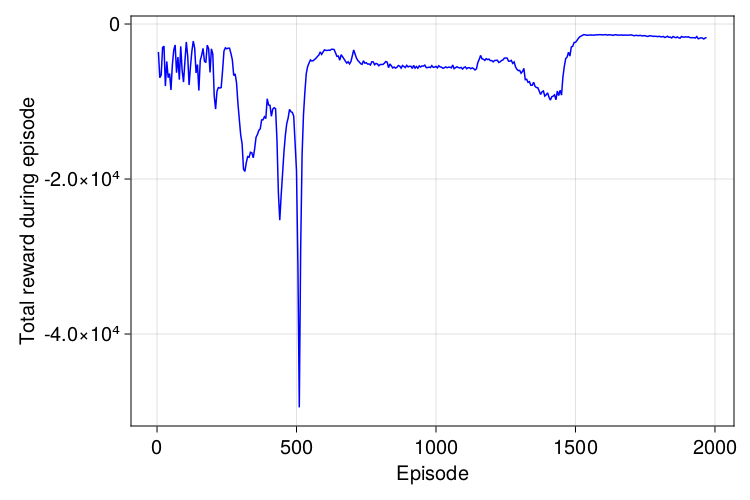

In [4]:
using CairoMakie
res = 750 
fontsize = 20
f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)

ax = Axis(f[1, 1],
    xlabel = "Episode",
    ylabel = "Total reward during episode",
    #yscale = log10
)

last = length(hookResults)
eps = collect(1:last) .* parameters["episodeStride"]
Makie.lines!(eps,  1 .* GetRewards(hookResults, last), color = :blue)

current_figure()

In [32]:
argmax(GetRewards(hookResults, last))

241

In [25]:
2e-4*2500 * 50

25.0

In [21]:
parameters["bounds"]

2-element Vector{Float64}:
 20.0
  0.15

In [36]:
[sum(hookResults[ep].rewards[1:end-1])  for ep in 1:last]

200-element Vector{Float64}:
 -17.69878721437067
 -20.65049968839363
 -18.152983854656448
 -18.487887072778037
 -20.825335337005498
 -19.09561824696957
 -19.637689062743767
 -20.03732983354544
 -19.00798643975638
 -20.745725878417336
 -21.094626809825808
 -23.607823860820087
 -19.065442364199335
   ⋮
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769
  -3.100796913629769

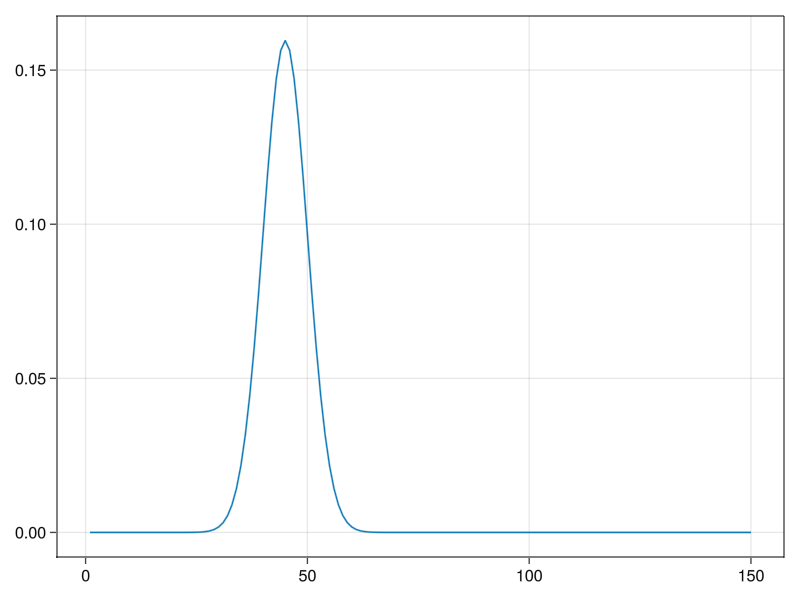

In [11]:
gaussianSoAFunc2D(grid, a, r0, s) = ScalarSoA2D([a * gaussian(r, r0, s) for r in 1:grid.Nx, y in 1:1])

Makie.lines(gaussianSoAFunc2D(Grid2D(150, 1, 0.0), 2, 45, 5).Values[1:end])

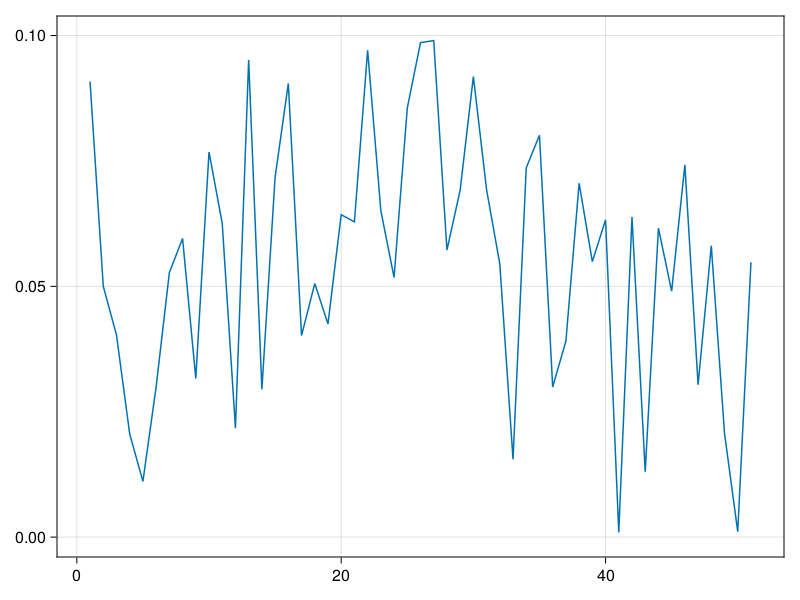

In [15]:
ep = 10
Makie.lines([findmax(ex.hook.stateTrajList[ep][t].gammaSoA.Values[1:end])[1] for t in 1:51])

In [10]:
ex.hook.stateTrajList[ep][50]

LoadError: MethodError: no method matching keys(::JLD2.ReconstructedTypes.var"##Main.SimMainRL.SimState#349")

[0mClosest candidates are:
[0m  keys([91m::Union{Tables.AbstractColumns, Tables.AbstractRow}[39m)
[0m[90m   @[39m [35mTables[39m [90m~/.julia/packages/Tables/AcRIE/src/[39m[90m[4mTables.jl:189[24m[39m
[0m  keys([91m::IndexStyle[39m, [91m::AbstractArray[39m, [91m::AbstractArray...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:397[24m[39m
[0m  keys([91m::Tuple[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mtuple.jl:71[24m[39m
[0m  ...


In [26]:
parameters["dx"]

1.0

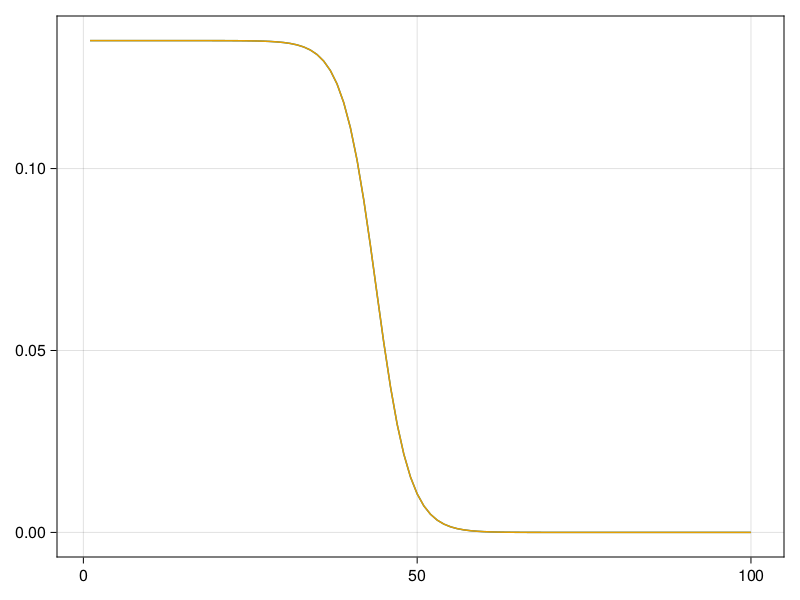

In [20]:
using LsqFit
yvals = ex.hook.stateTrajList[ep][end].gammaSoA.Values[1:end];
xvals = collect(1:length(yvals))

ss = 5;
model(x,p) = p[1] * 0.5 * (1 - tanh((x - p[2]) / ss))
fit = curve_fit((x, p) -> model.(x, Ref(p)), xvals, yvals, [12.0, 32.0])
fit.param

Makie.lines(model.(xvals,Ref(fit.param)))
Makie.lines!(xvals, yvals)
current_figure()

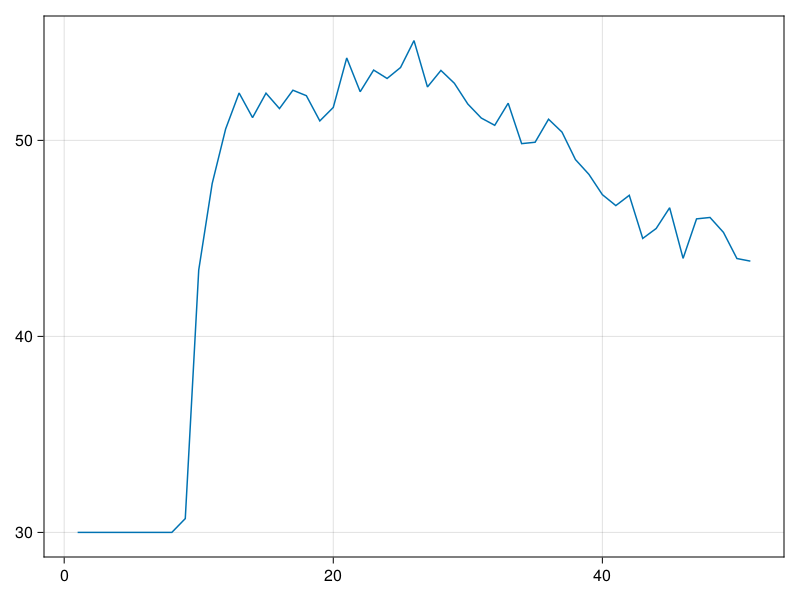

In [33]:


Makie.lines(p2List)

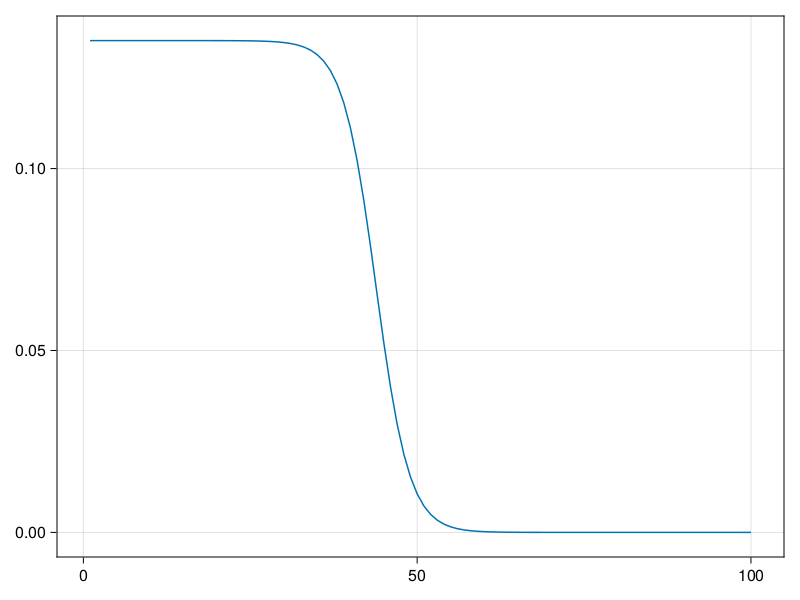

In [11]:

ep = 350
Makie.lines(ex.hook.stateTrajList[ep][end].gammaSoA.Values[1:end])
#Makie.lines(ex.hook.stateTrajList[ep][1].cF.CBISoA.Values[1:end])
#Makie.lines(ex.hook.stateTrajList[ep][1].dF.uxSoA.Values[1:end])
#Makie.lines(ex.hook.stateTrajList[ep][50].dF.uxSoA.Values[1:end])

#Makie.ylims!(0,0.1)
current_figure()

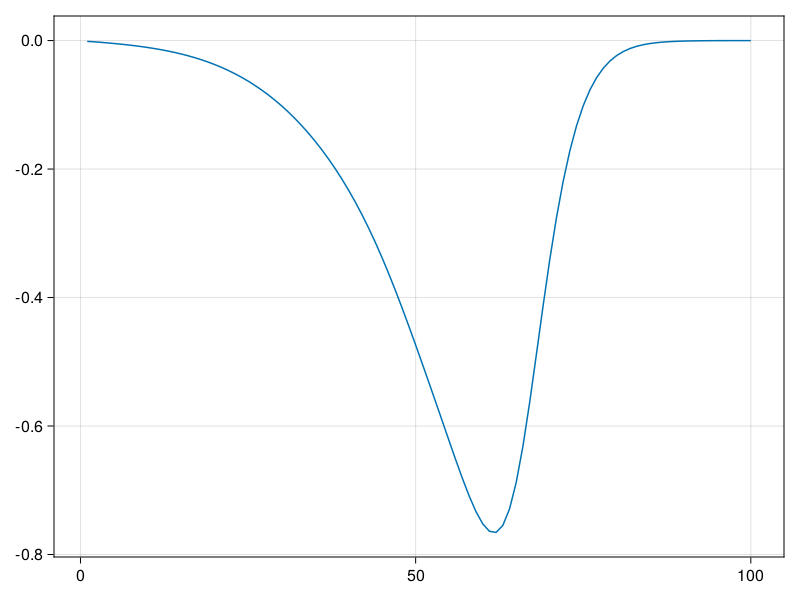

In [16]:
ep = 260
t = 50
Makie.lines(ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[1:end])

maxk (generic function with 1 method)

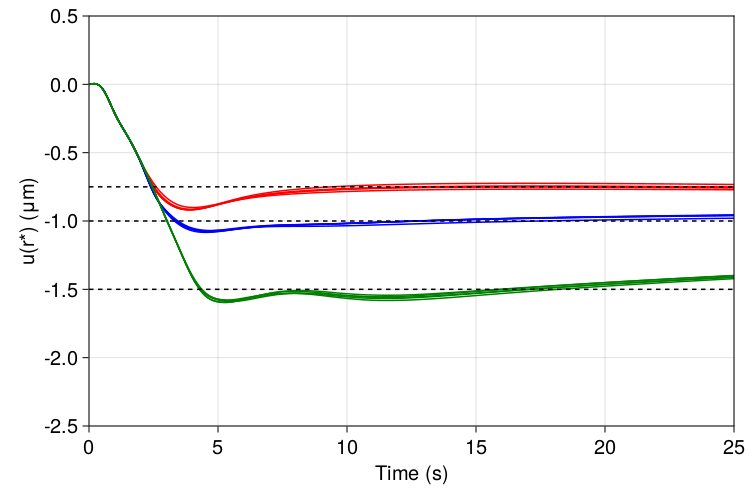

In [25]:

res = 750 
fontsize = 20
f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)

ax = Axis(f[1, 1],
    xlabel = "Time (s)",
    ylabel = "u(r*) (μm)",
    #xgridvisible = :false,
    #ygridvisible = :false
)

colors = [:red,:blue,:green]


pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_" * "_1p5"
seeds = [20,40,20]
points = ["0p75","1p0","1p5"]
for i = 1:3
    pathBaseSpec = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_" * points[i]
    seed = seeds[i]
    pathName = pathBaseSpec * "/seed_" * string(seed) * "/" 
    @suppress_err d = load(pathName * "SavedData.jld2")
    #d = load(pathName * "SavedData.jld2")
    parameters = d["parameters"];
    ex = d["ex"];
    hookResults = ex.hook.episodeList;
    last = length(hookResults)
    eps = collect(1:last) .* parameters["episodeStride"]
    
    ust = parameters["ust"]
    neps = 5
    eps = maxk(GetRewards(hookResults, last),neps)
    #eps = [eps[1],eps[100],eps[200],eps[300]]
    timeDomain = collect(1:(length(ex.hook.stateTrajList[1]))) #.* (parameters["ndt"] * parameters["dt"])
    for n=1:length(eps)
        ep = eps[n][1]
        timeDomain = collect(1:(length(ex.hook.stateTrajList[ep]))) #.* (parameters["ndt"] * parameters["dt"])
        uVals = [ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[50] for t in 1:length(timeDomain)]
        
        (tI, uI) = InterpolateFunction(timeDomain, uVals, 5)
        tI = (tI .- 1).* (parameters["ndt"] * parameters["dt"])
        Makie.lines!(tI, uI, color = colors[i])

    end
    Makie.lines!(timeDomain.-1, [ust for t in 0:length(timeDomain)-1], linestyle = :dash, color = :black) 
end

Makie.ylims!(-2.5, 0.5)
Makie.xlims!(-0,25)

#figurePath = "/Users/csfloyd/Dropbox/Shared/Tcb2_paper_2024/AI Files/figure5/"
#save(figurePath * "RLResults.png", f, px_per_unit = 3)


current_figure()

In [ ]:
clip()

┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 C:\Users\csfloyd\.julia\packages\JLD2\ryhNR\src\data\reconstructing_datatypes.jl:164
┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 C:\Users\csfloyd\.julia\packages\JLD2\ryhNR\src\data\reconstructing_datatypes.jl:164
┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 C:\Users\csfloyd\.julia\packages\JLD2\ryhNR\src\data\reconstructing_datatypes.jl:164


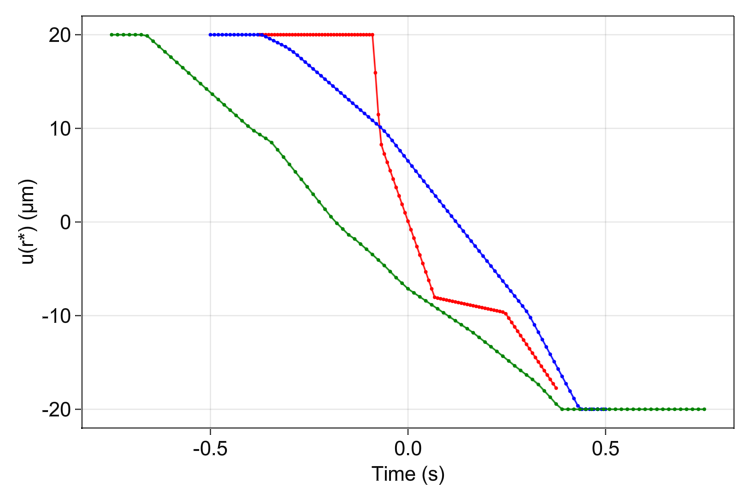

In [40]:
using CairoMakie
using Suppressor: @suppress_err
res = 750 
fontsize = 20
f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)

ax = Axis(f[1, 1],
    xlabel = "Time (s)",
    ylabel = "u(r*) (μm)",
    #xgridvisible = :false,
    #ygridvisible = :false
)

colors = [:red,:blue,:green]


#seeds = [40,10,40]
seeds = [20,40,20]
points = ["0p75","1p0","1p5"]
for i = 1:3
    pathBaseSpec = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_" * points[i]
    seed = seeds[i]
    pathName = pathBaseSpec * "/seed_" * string(seed) * "/" 
    #@suppress_err d = load(pathName * "SavedData.jld2")
    d = load(pathName * "SavedData.jld2")
    parameters = d["parameters"];
    ex = d["ex"];
    hookResults = ex.hook.episodeList;
    
    targetActions = []
    behaviorActions = []

    ps = collect(-0.5:0.01:0.5)
    bnd = parameters["bounds"][1]
    rst = parameters["rst"]
    ust = parameters["ust"]

    for p in ps
        #behaviorAction = 0.5 * bnd * (clamp(ex.policy.policy.behavior_actor.model([p])[2], -1, 1) + 1.0) + 0.01
        behaviorAction = bnd*clamp(ex.policy.policy.behavior_actor.model([p])[1], -1, 1) #+ rst
        push!(behaviorActions, behaviorAction)
    end

    psScaled = ps .* ust #.+ ust
    Makie.lines!(psScaled, Vector{Float64}(behaviorActions), color = colors[i])
    Makie.scatter!(psScaled, Vector{Float64}(behaviorActions), color = colors[i], markersize = 5)

    
end

#Makie.ylims!(0, 0.2)
#Makie.ylims!(0, 100)
#Makie.xlims!(-0,25)

#figurePath = "/Users/csfloyd/Dropbox/Shared/Tcb2_paper_2024/AI Files/figure5/"
#save(figurePath * "RLResults.png", f, px_per_unit = 3)


current_figure()

┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 C:\Users\csfloyd\.julia\packages\JLD2\ryhNR\src\data\reconstructing_datatypes.jl:164
┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 C:\Users\csfloyd\.julia\packages\JLD2\ryhNR\src\data\reconstructing_datatypes.jl:164
┌ Warning: saved type ADAM is missing field epsilon in workspace type; reconstructing
└ @ JLD2 C:\Users\csfloyd\.julia\packages\JLD2\ryhNR\src\data\reconstructing_datatypes.jl:164


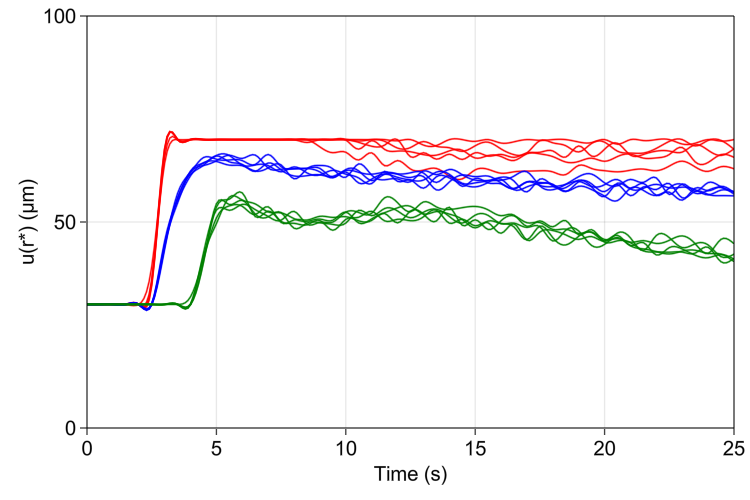

In [41]:
using CairoMakie
using Suppressor: @suppress_err
res = 750 
fontsize = 20
f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)

ax = Axis(f[1, 1],
    xlabel = "Time (s)",
    ylabel = "u(r*) (μm)",
    #xgridvisible = :false,
    #ygridvisible = :false
)

colors = [:red,:blue,:green]


pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_" * "_1p5"
#seeds = [40,10,40]
seeds = [20,40,20]
points = ["0p75","1p0","1p5"]
for i = 1:3
    pathBaseSpec = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_" * points[i]
    seed = seeds[i]
    pathName = pathBaseSpec * "/seed_" * string(seed) * "/" 
    #@suppress_err d = load(pathName * "SavedData.jld2")
    d = load(pathName * "SavedData.jld2")
    parameters = d["parameters"];
    ex = d["ex"];
    hookResults = ex.hook.episodeList;
    last = length(hookResults)
    eps = collect(1:last) .* parameters["episodeStride"]
    
    ust = parameters["ust"]
    neps = 5
    eps = maxk(GetRewards(hookResults, last),neps)
    #eps = [eps[1],eps[100],eps[200],eps[300]]
    timeDomain = collect(1:(length(ex.hook.stateTrajList[1]))) #.* (parameters["ndt"] * parameters["dt"])
    for n=1:length(eps)
        ep = eps[n][1]
        
        timeDomain = collect(1:(length(ex.hook.stateTrajList[ep]))) #.* (parameters["ndt"] * parameters["dt"])
        #uVals = [ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[50] for t in 1:length(timeDomain)]
        (p1List, p2List) = GetActions(ex.hook.stateTrajList[ep]);
        # print(length(p1List))
        # print(length(uVals))
        
        uVals = p2List;
        
        (tI, uI) = InterpolateFunction(timeDomain, uVals, 5)
        tI = (tI .- 1).* (parameters["ndt"] * parameters["dt"])
        Makie.lines!(tI, uI, color = colors[i])
        
        

    end
    Makie.lines!(timeDomain.-1, [ust for t in 0:length(timeDomain)-1], linestyle = :dash, color = :black) 
end

#Makie.ylims!(0, 0.2)
Makie.ylims!(0, 100)
Makie.xlims!(-0,25)

#figurePath = "/Users/csfloyd/Dropbox/Shared/Tcb2_paper_2024/AI Files/figure5/"
#save(figurePath * "RLResults.png", f, px_per_unit = 3)


current_figure()

In [32]:
## save area data

using DataFrames, CSVFiles, CSV
using DelimitedFiles

pathBase = "/Users/csfloyd/Dropbox/Shared/Tcb2_paper_2024/AI files/ModelDataForPaper/"

subDir = "RL" 
pathOut = pathBase * subDir * "/"

pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_" * "_1p5"
#seeds = [40,10,40]

seeds = [20,40,20]
points = ["0p75","1p0","1p5"]
nI = 4
for i = 1:3
    pathBaseSpec = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_RL/Dirs_seed_ks_" * points[i]
    seed = seeds[i]
    pathName = pathBaseSpec * "/seed_" * string(seed) * "/" 
    @suppress_err d = load(pathName * "SavedData.jld2")
    parameters = d["parameters"];
    ex = d["ex"];
    hookResults = ex.hook.episodeList;
    last = length(hookResults)
    eps = collect(1:last) .* parameters["episodeStride"]
    
    ust = parameters["ust"]
    neps = 5
    eps = maxk(GetRewards(hookResults, last),neps)
   
    for n=1:length(eps)
        ep = eps[n][1]
        
        timeDomain = collect(1:(length(ex.hook.stateTrajList[ep]))) 
        (p1List, p2List) = GetActions(ex.hook.stateTrajList[ep]);
        
        
        (tI, up1) = InterpolateFunction(timeDomain, p1List, nI)
        tI = (tI .- 1).* (parameters["ndt"] * parameters["dt"])
        itp1 = DataFrame(Times_s = tI, u = up1)
        
        
        (tI, up2) = InterpolateFunction(timeDomain, p2List, nI)
        tI = (tI .- 1).* (parameters["ndt"] * parameters["dt"])
        itp2 = DataFrame(Times_s = tI, u = up2)
        
        uVals = [ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[50] for t in 1:length(timeDomain)]
        (tI, uu) = InterpolateFunction(timeDomain, uVals, nI)
        tI = (tI .- 1).* (parameters["ndt"] * parameters["dt"])
        itu = DataFrame(Times_s = tI, u = uu)
        
        save(pathOut * points[i] * "/" * string(n) * "p1.csv", itp1)
        save(pathOut * points[i] * "/" * string(n) * "p2.csv", itp2)
        save(pathOut * points[i] * "/" * string(n) * "u.csv", itu)
    end
    
end

print("Done");

Done

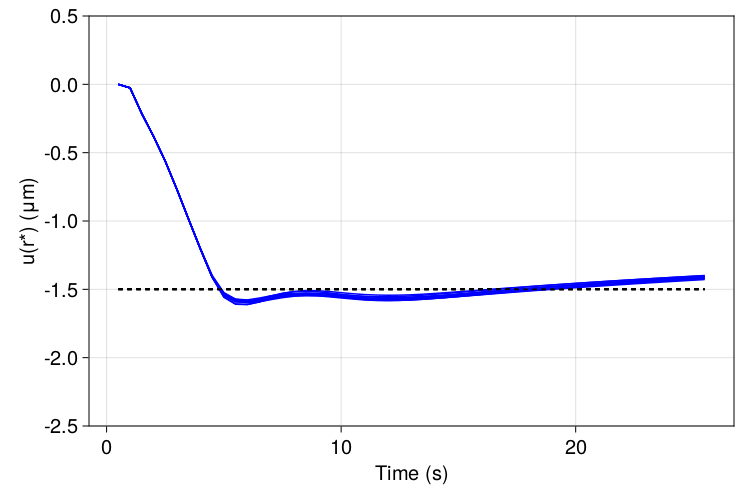

In [52]:
using CairoMakie
res = 750 
fontsize = 20
f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)

ax = Axis(f[1, 1],
    xlabel = "Time (s)",
    ylabel = "u(r*) (μm)"
)


ust = parameters["ust"]

neps = 10

ep = 340
ep = argmax(GetRewards(hookResults, last))
eps = maxk(GetRewards(hookResults, last),neps)

for i=1:neps
    ep = eps[i][1]
    timeDomain = collect(1:length(ex.hook.stateTrajList[ep])) .* (parameters["ndt"] * parameters["dt"])
    Makie.lines!(timeDomain, [ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[50] for t in 1:length(timeDomain)], color = :blue)
    Makie.lines!(timeDomain, [ust for t in 1:length(timeDomain)], linestyle = :dash, color = :black)
end

Makie.ylims!(-2.5, 0.5)

current_figure()

5-element Vector{Tuple{Int64, Float64}}:
 (26, -996.6856288445721)
 (36, -1065.356053343724)
 (29, -1209.5958564104444)
 (122, -1255.085970567641)
 (114, -1268.409984783417)

In [32]:
ep

26

In [49]:
2500*2e-4 #* 50

0.5

In [17]:
2e-4 * 1250

0.25

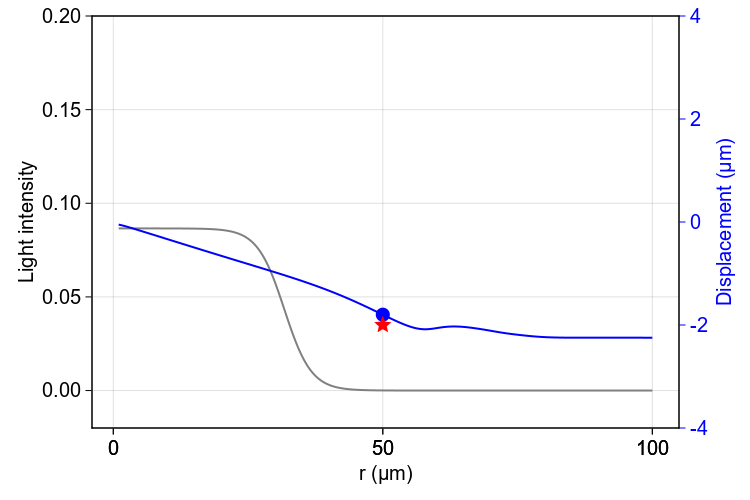

In [37]:
using Interpolations

function InterpolateFunction(rDomain, values, factor)
    dr = rDomain[2] - rDomain[1]
    rMaxm1 = rDomain[end]
    drNew = dr / factor
    newRDomain = collect(1:drNew:(rDomain[end]))
    itp = interpolate(values, BSpline(Cubic(Line(OnGrid()))))
    iFunc = scale(itp, 1:dr:(rMaxm1))
    return (newRDomain, iFunc.(newRDomain))
end

Interp(rDomain, values) = InterpolateFunction(rDomain, values, 5)

rst = parameters["rst"]
ust = parameters["ust"]
ep = 230

rDomain = collect(1:1:100) 
extendFac = 5

using CairoMakie
res = 750 
fontsize = 20
f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)

ax = Axis(f[1, 1],
    xlabel = "r (μm)",
    ylabel = "Light intensity"
)
Makie.ylims!(ax, (-0.02,0.2))


axt = Axis(f[1, 1],
        ylabel = "Displacement (μm)",
        yticklabelcolor = :blue,
        ytickcolor = :blue,
        ylabelcolor = :blue,
        xgridvisible = false,
        ygridvisible = false
    )
axt.yaxisposition = :right
linkxaxes!(axt,ax)
Makie.ylims!(axt, (-4.0,4.0))

global t = 1
newRvals = Interp(rDomain, ex.hook.stateTrajList[ep][t].gammaSoA.Values[1:end])[1]
uVals = Observable(Interp(rDomain, ex.hook.stateTrajList[ep][t].gammaSoA.Values[1:end])[2])
gammaVals = Observable(Interp(rDomain, ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[1:end])[2])
urst = Observable(ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[1:end][rst])

Makie.lines!(ax, newRvals, uVals, color = :gray, linewidth = 2)

Makie.lines!(axt, newRvals, gammaVals, color = :blue, linewidth = 2)
Makie.scatter!(axt, rst, urst, color = :blue, marker = :circle, markersize = 20)
Makie.scatter!(axt, rst, ust, color = :red, marker = :star5, markersize = 20)


moviePath = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Movies/RLMovies/Learned2p0Tanh1e-2.mp4"
record(f, moviePath, 1:(extendFac * (length(ex.hook.stateTrajList[ep]) - 1)), framerate = 24) do tt
    if tt % extendFac == 0
        global t += 1
    end
    uVals[] = Interp(rDomain, ex.hook.stateTrajList[ep][t].gammaSoA.Values[1:end])[2]
    gammaVals[] = Interp(rDomain, ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[1:end])[2]
    urst[] = ex.hook.stateTrajList[ep][t].dF.uxSoA.Values[1:end][rst]
end

current_figure()

abs.(ex.hook.actorLossList)[end] = 0.005073803f0
abs.(ex.hook.actorLossList)[end] = 0.005073803f0


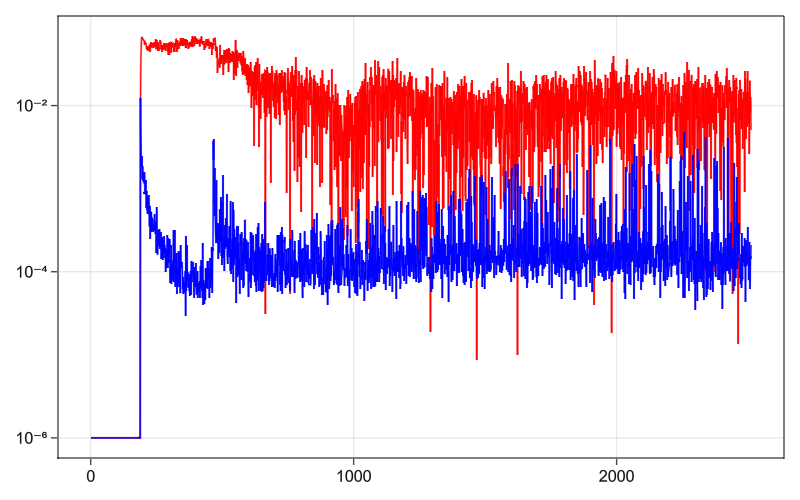

In [12]:
f = Figure(resolution = (800, 500), fontsize = 16, font = "Arial", dpi = 300)
ax = Axis(f[1, 1], yscale = log10)

xs = collect(1:(length(ex.hook.actorLossList)))
Makie.lines!(xs, abs.(ex.hook.actorLossList) .+ 1e-6, color = :red)
Makie.lines!(xs, abs.(ex.hook.criticLossList).+ 1e-6, color = :blue)


@show abs.(ex.hook.actorLossList)[end]
@show abs.(ex.hook.actorLossList)[end]
f

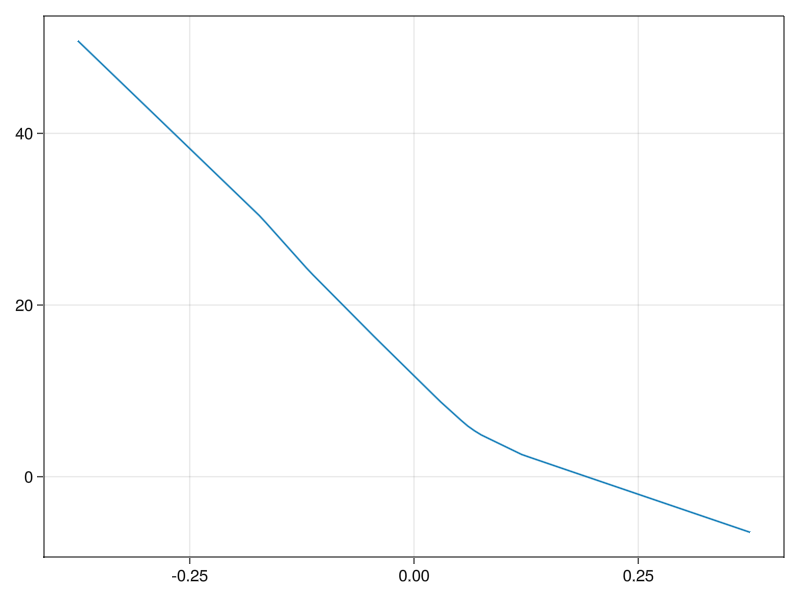

In [18]:
targetActions = []
behaviorActions = []

ps = collect(-0.5:0.01:0.5)
bnd = parameters["bounds"][1]
rst = parameters["rst"]
ust = parameters["ust"]

for p in ps
    targetAction = bnd*ex.policy.policy.target_actor.model([p])[1] #+ rst
    behaviorAction = bnd*ex.policy.policy.behavior_actor.model([p])[1] #+ rst
    push!(targetActions, targetAction)
    push!(behaviorActions, behaviorAction)
end

psScaled = ps .* ust #.+ ust
Makie.lines(psScaled, Vector{Float64}(behaviorActions))
#Makie.xlabel!("Bead position relative to goal")

current_figure()

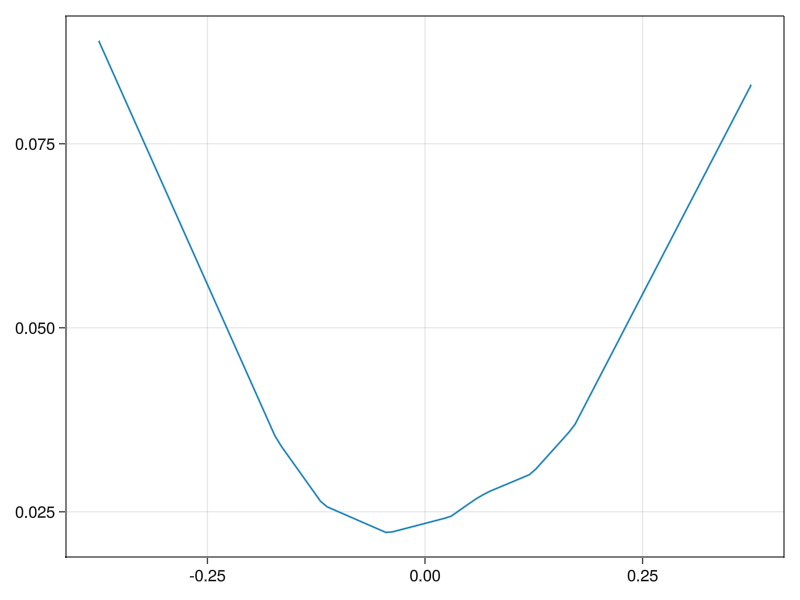

In [21]:
targetActions = []
behaviorActions = []

ps = collect(-0.5:0.01:0.5)
bnd = parameters["bounds"][2]
rst = parameters["rst"]
ust = parameters["ust"]

for p in ps
    #targetAction = bnd*ex.policy.policy.target_actor.model([p])[1] 
    behaviorAction = 0.5 * bnd * (ex.policy.policy.behavior_actor.model([p])[2] + 1.0) + 0.01
    #push!(targetActions, targetAction)
    push!(behaviorActions, behaviorAction)
end

psScaled = ps .* ust #.+ ust
Makie.lines(psScaled, Vector{Float64}(behaviorActions))
#Makie.xlabel!("Bead position relative to goal")

current_figure()

In [ ]:
targetActions = []
behaviorActions = []

ps = collect(-0.5:0.01:0.5)
bnd = parameters["bounds"][1]
rst = parameters["rst"]
ust = parameters["ust"]

for p in ps
    targetAction = bnd*ex.policy.policy.target_actor.model([p])[1] #+ rst
    behaviorAction = bnd*ex.policy.policy.behavior_actor.model([p])[1] #+ rst
    push!(targetActions, targetAction)
    push!(behaviorActions, behaviorAction)
end

psScaled = ps .* ust #.+ ust
Makie.lines(psScaled, Vector{Float64}(behaviorActions))
#Makie.xlabel!("Bead position relative to goal")

current_figure()

In [8]:
parameters["rst"]

50

(a, r0, s) = (1.0, 75.0, 10.0)


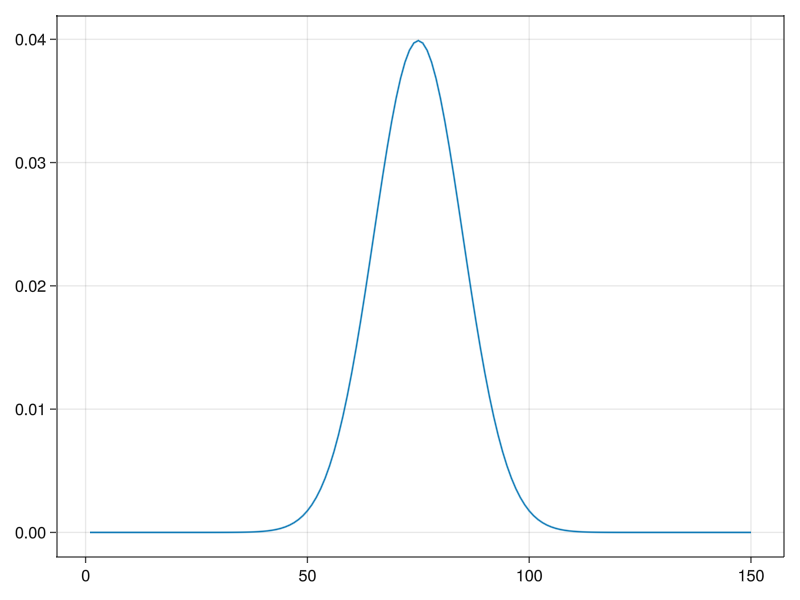

In [56]:
action = -[-1.0, 1.0, -1.0]
bounds = parameters["bounds"]
a = bounds[1] * 0.5 * (action[1] + 1.0)
r0 = 75 + bounds[2] * 0.5 * (action[2] + 1.0)
s = bounds[3] * (0.5) * (action[3] + 1.0) + 5.0
@show a, r0, s
myGrid = Grid2D(150,1,1)
gammaSoA = gaussianSoAFunc2D(myGrid, a, r0, s)
Makie.lines(gammaSoA.Values[1:end])

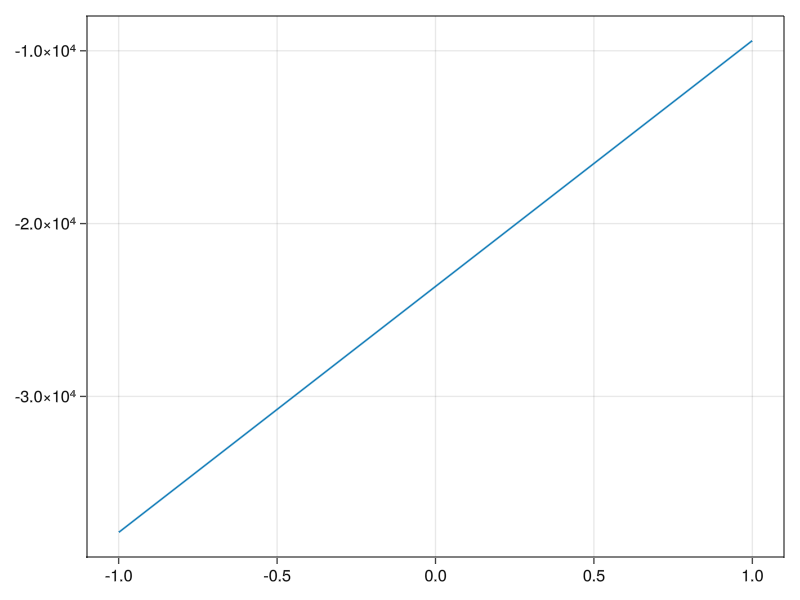

In [29]:
targetActions = []
behaviorActions = []

ps = collect(-1:0.1:1)

for p in ps
    targetAction = ex.policy.policy.target_actor.model([p,0.0])
    behaviorAction = ex.policy.policy.behavior_actor.model([p, 0.0])
    push!(targetActions, targetAction[1])
    push!(behaviorActions, behaviorAction[1])
end

Makie.lines(ps, Vector{Float64}(targetActions))

current_figure()

In [41]:
rotAngle = -pi/2 # -2*pi/3
rotMatrix = [cos(rotAngle) -sin(rotAngle); sin(rotAngle) cos(rotAngle)]
v = [cos(pi/3), sin(pi/3)]
@show v
rotv = [rotMatrix[1,1] * v[1] + rotMatrix[1,2] * v[2], rotMatrix[2,1] * v[1] + rotMatrix[2,2] * v[2]]

v = [0.5000000000000001, 0.8660254037844386]


2-element Vector{Float64}:
  0.5
 -0.8660254037844386

In [43]:
Cx = 2 * 1e-8 / 1e-6
0.4 / Cx


20.0